In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_auc_curve(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# def evaluate_classification(y_true, y_pred, y_prob):
#     plot_confusion_matrix(y_true, y_pred)
    
#     print("Classification Report:")
#     print(classification_report(y_true, y_pred))
    
#     plot_roc_auc_curve(y_true, y_prob)


from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, precision_recall_curve, average_precision_score

def evaluate_classification(y_true, y_pred, y_prob):
    # Select the probabilities of the positive class
    y_prob_positive = y_prob #[:, 1]
    
    plot_confusion_matrix(y_true, y_pred)
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"Cohen's Kappa: {kappa:.4f}")
    
    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    
    precision, recall, _ = precision_recall_curve(y_true, y_prob_positive)
    ap = average_precision_score(y_true, y_prob_positive)
    print(f"Average Precision: {ap:.4f}")
    
    plot_roc_auc_curve(y_true, y_prob_positive)


In [2]:
data = pd.read_csv('./data/Sampled_data_train.csv')
data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3493085.0,0.0,13264386.0,314.950,W,1444.0,490.0,150.0,visa,166.0,...,missing,-1.0,missing,missing,missing,missing,missing,missing,missing,missing
1,3520085.0,0.0,14052685.0,117.000,W,3681.0,513.0,150.0,visa,166.0,...,missing,-1.0,missing,missing,missing,missing,missing,missing,missing,missing
2,3329023.0,0.0,8439647.0,92.745,C,3335.0,545.0,185.0,visa,138.0,...,ie 11.0 for desktop,-1.0,missing,missing,F,T,T,F,desktop,Trident/7.0
3,3408925.0,0.0,10689293.0,200.000,R,12607.0,399.0,150.0,american express,185.0,...,chrome 65.0,24.0,1600x900,match_status:2,T,F,T,F,desktop,Windows
4,3075828.0,0.0,1874266.0,226.000,W,10795.0,555.0,150.0,visa,226.0,...,missing,-1.0,missing,missing,missing,missing,missing,missing,missing,missing


In [30]:
X = data.drop(['TransactionID','isFraud'],axis = 1)
y = data['isFraud']

In [31]:
from sklearn.model_selection import train_test_split

X_train , X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3 , stratify = y, random_state = 42)

X_train.shape , y_train.shape , X_test.shape , y_test.shape #, X_val.shape , y_val.shape

((70000, 432), (70000,), (30000, 432), (30000,))

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define the numerical and categorical column names

# Get the data types of each column
dtypes = X_train.dtypes

# Find the numerical columns
numerical_cols = dtypes[dtypes != 'object'].index.tolist()

# Find the categorical columns
categorical_cols = dtypes[dtypes == 'object'].index.tolist()

# Define the column transformer for scaling and one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Define the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


In [33]:
# Transform the data
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the neural network model
def create_baseline_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

from tensorflow.keras.metrics import Recall

# Instantiate the model
baseline_model = create_baseline_model()


from tensorflow.keras.metrics import TruePositives, FalsePositives, FalseNegatives

# Compile the model
baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=[TruePositives(name='tp'), FalsePositives(name='fp'), FalseNegatives(name='fn')])

# Train the model
history = baseline_model.fit(X_train, y_train,
                             validation_split=0.2,
                             batch_size=32,
                             epochs=20,
                             verbose=1)

# Evaluate the model on the test set
_, test_tp, test_fp, test_fn = baseline_model.evaluate(X_test, y_test, verbose=0)

# Calculate recall
test_recall = test_tp / (test_tp + test_fn)
print(f'Test recall (minority class): {test_recall}')


Epoch 1/20
1750/1750 [==============================] - 12s 6ms/step - loss: 0.4021 - tp: 4272.0000 - fp: 1655.0000 - fn: 7331.0000 - val_loss: 0.3585 - val_tp: 1060.0000 - val_fp: 170.0000 - val_fn: 1801.0000
Epoch 2/20
1750/1750 [==============================] - 16s 9ms/step - loss: 0.3563 - tp: 4953.0000 - fp: 1231.0000 - fn: 6650.0000 - val_loss: 0.3264 - val_tp: 1106.0000 - val_fp: 161.0000 - val_fn: 1755.0000
Epoch 3/20
1750/1750 [==============================] - 8s 4ms/step - loss: 0.3446 - tp: 5224.0000 - fp: 1198.0000 - fn: 6379.0000 - val_loss: 0.3185 - val_tp: 1209.0000 - val_fp: 170.0000 - val_fn: 1652.0000
Epoch 4/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.3336 - tp: 5460.0000 - fp: 1180.0000 - fn: 6143.0000 - val_loss: 0.3135 - val_tp: 1185.0000 - val_fp: 128.0000 - val_fn: 1676.0000
Epoch 5/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.3247 - tp: 5642.0000 - fp: 1180.0000 - fn: 5961.0000 - val_loss: 0.3087 - val_tp: 12

In [16]:
def fgsm_attack(input_data, epsilon, model, true_labels, min_val, max_val):
    input_data = tf.convert_to_tensor(input_data, dtype=tf.float32)
    true_labels = tf.convert_to_tensor(true_labels, dtype=tf.float32)
    
    # Reshape the true_labels tensor to match the predictions shape
    true_labels = tf.reshape(true_labels, (-1, 1))
    
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        predictions = model(input_data)
        loss = tf.keras.losses.binary_crossentropy(true_labels, predictions)
    
    gradients = tape.gradient(loss, input_data)
    signed_grad = tf.sign(gradients)
    adversarial_examples = input_data + epsilon * signed_grad
    adversarial_examples = tf.clip_by_value(adversarial_examples, min_val, max_val)  # Clip values to the valid range
    
    return adversarial_examples.numpy()

# Define a helper function to reverse the scaling
def inverse_scale(X_scaled, numerical_transformer, num_cols):
    X_num = X_scaled[:, :num_cols]
    X_num_inverse = numerical_transformer.inverse_transform(X_num)
    return X_num_inverse

# Get the numerical_transformer from the pipeline
numerical_transformer = pipeline.named_steps['preprocessor'].named_transformers_['num']

# Calculate the number of numerical columns in the transformed dataset
num_numerical_cols = len(numerical_cols)

# Calculate the minimum and maximum values of the unscaled data
min_val = np.min(inverse_scale(X_train, numerical_transformer, num_numerical_cols))
max_val = np.max(inverse_scale(X_train, numerical_transformer, num_numerical_cols))

epsilon = 0.01  # Choose a small value for epsilon (e.g., 0.01)
adversarial_examples = fgsm_attack(X_train, epsilon, baseline_model, y_train, min_val, max_val)


In [17]:
adversarial_examples.shape

(70000, 973)

In [21]:
from sklearn.metrics import recall_score

# Make predictions on the adversarial examples
adversarial_predictions = (baseline_model.predict(adversarial_examples) > 0.5).astype("int32")

# Calculate the recall score for the minority class on adversarial examples
adversarial_recall = recall_score(y_train, adversarial_predictions)

print(f'Original test recall (minority class): {test_recall}')
print(f'Adversarial recall (minority class): {adversarial_recall}')


2188/2188 [==============================] - 6s 3ms/step
Original test recall (minority class): 0.5644458783674786
Adversarial recall (minority class): 0.37520741150442477


The results show that the model's performance on adversarial examples is worse than on the original test data. The recall score for the minority class dropped from 0.5644 to 0.3752 when evaluating the model on the adversarial examples generated with FGSM.

This indicates that your model is susceptible to adversarial attacks and could benefit from techniques to improve its robustness against such attacks. Some possible techniques include:

1. Adversarial training: Train the model using both original and adversarial examples. This can help the model learn to recognize and correctly classify adversarial examples.

2. Input transformations: Apply input transformations (e.g., feature squeezing, spatial smoothing) to mitigate the effect of adversarial perturbations before passing the data through the model.

3. Defensive distillation: Train a more robust model by using the output probabilities of a "teacher" model to train a "student" model, rather than using the hard labels.

4. Gradient masking: Apply regularization or other techniques to make the model's gradients less informative for an attacker, making it harder to craft successful adversarial examples.

Keep in mind that no single technique can provide complete protection against adversarial attacks. You may need to experiment with different combinations of these techniques to find the best approach for your specific problem.

In [57]:
# Load the model from the file
with open("xgb_best_f1_score.pkl", "rb") as f:
    xgb_model = pickle.load(f)


In [58]:
# import xgboost as xgb
# xgb_model = xgb.XGBRFClassifier().fit(X_train,y_train)

In [59]:
def calculate_finite_differences(xgb_model, tree, X, epsilon):
    X_plus = X.copy()
    X_minus = X.copy()

    for feature_idx in tree["Feature"].unique():
        if feature_idx != "Leaf":
            X_plus[:, int(feature_idx[1:])] += epsilon
            X_minus[:, int(feature_idx[1:])] -= epsilon

    y_plus = xgb_model.predict_proba(X_plus)[:, 1]
    y_minus = xgb_model.predict_proba(X_minus)[:, 1]

    finite_diff = (y_plus - y_minus) / (2 * epsilon)
    return finite_diff.reshape(-1, 1)


In [60]:
def fgmt_attack(xgb_model, X, epsilon):
    booster = xgb_model.get_booster()
    trees_df = booster.trees_to_dataframe()

    total_gradients = np.zeros_like(X)

    for tree_id in range(xgb_model.best_ntree_limit):
        tree = trees_df[trees_df["Tree"] == tree_id]
        total_gradients += calculate_finite_differences(xgb_model, tree, X, epsilon)

    signed_grad = np.sign(total_gradients)
    adversarial_examples = X + epsilon * signed_grad
    return adversarial_examples


In [61]:
epsilon = 0.01  # Choose a small value for epsilon (e.g., 0.01)
adversarial_examples_xgb = fgmt_attack(xgb_model, X_test, epsilon)

# Evaluate the XGBoost model on the original test set
original_recall = recall_score(y_test, xgb_model.predict(X_test))
print(f"Original test recall (minority class): {original_recall}")

# Evaluate the XGBoost model on the adversarial examples
adversarial_recall = recall_score(y_test, xgb_model.predict(adversarial_examples_xgb))
print(f"Adversarial recall (minority class): {adversarial_recall}")


Original test recall (minority class): 0.8273915147604453
Adversarial recall (minority class): 0.8791740603323117


Thank you for providing the updated recall values.

The original test recall (minority class) is now 0.8274, which means the model correctly identified around 82.74% of the minority class samples in the original test set. After applying the FGMT attack, the adversarial recall (minority class) is 0.8792, which means the model correctly identified around 87.92% of the minority class samples in the adversarial examples.

Again, it appears that the adversarial recall is higher than the original recall. As mentioned before, this might indicate that the FGMT attack is not very effective on this specific model or that the model is somewhat robust to small perturbations in the input data. To gain a better understanding of your model's robustness, it's important to test it against a variety of adversarial attacks and make any necessary adjustments to improve its resilience.

In [63]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Activation


def create_improved_model():
    model = Sequential()
    model.add(Dense(128, input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

# Instantiate the model
improved_model = create_improved_model()

# Compile the model
improved_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy', Recall()])

# Set the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)

# Train the model
history = improved_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[lr_scheduler])


Epoch 1/100
875/875 [==============================] - 11s 6ms/step - loss: 0.4198 - accuracy: 0.8267 - recall: 0.3768 - val_loss: 0.3504 - val_accuracy: 0.8603 - val_recall: 0.3953 - lr: 0.0010
Epoch 2/100
875/875 [==============================] - 5s 6ms/step - loss: 0.3664 - accuracy: 0.8504 - recall: 0.4278 - val_loss: 0.3378 - val_accuracy: 0.8633 - val_recall: 0.4096 - lr: 0.0010
Epoch 3/100
875/875 [==============================] - 5s 6ms/step - loss: 0.3555 - accuracy: 0.8576 - recall: 0.4495 - val_loss: 0.3306 - val_accuracy: 0.8666 - val_recall: 0.4124 - lr: 0.0010
Epoch 4/100
875/875 [==============================] - 6s 7ms/step - loss: 0.3449 - accuracy: 0.8612 - recall: 0.4680 - val_loss: 0.3201 - val_accuracy: 0.8713 - val_recall: 0.4715 - lr: 0.0010
Epoch 5/100
875/875 [==============================] - 6s 7ms/step - loss: 0.3412 - accuracy: 0.8637 - recall: 0.4800 - val_loss: 0.3188 - val_accuracy: 0.8734 - val_recall: 0.4869 - lr: 0.0010
Epoch 6/100
875/875 [========

875/875 [==============================] - 6s 7ms/step - loss: 0.2669 - accuracy: 0.8976 - recall: 0.6121 - val_loss: 0.2665 - val_accuracy: 0.8961 - val_recall: 0.5977 - lr: 0.0010
Epoch 44/100
875/875 [==============================] - 6s 7ms/step - loss: 0.2669 - accuracy: 0.8968 - recall: 0.6098 - val_loss: 0.2635 - val_accuracy: 0.8975 - val_recall: 0.5984 - lr: 0.0010
Epoch 45/100
875/875 [==============================] - 8s 9ms/step - loss: 0.2654 - accuracy: 0.8980 - recall: 0.6139 - val_loss: 0.2626 - val_accuracy: 0.8966 - val_recall: 0.5862 - lr: 0.0010
Epoch 46/100
875/875 [==============================] - 4s 5ms/step - loss: 0.2643 - accuracy: 0.8985 - recall: 0.6174 - val_loss: 0.2611 - val_accuracy: 0.8987 - val_recall: 0.6078 - lr: 0.0010
Epoch 47/100
875/875 [==============================] - 4s 5ms/step - loss: 0.2639 - accuracy: 0.8999 - recall: 0.6213 - val_loss: 0.2621 - val_accuracy: 0.8981 - val_recall: 0.6040 - lr: 0.0010
Epoch 48/100
875/875 [================

Epoch 83/100
875/875 [==============================] - 5s 6ms/step - loss: 0.2265 - accuracy: 0.9154 - recall: 0.6779 - val_loss: 0.2497 - val_accuracy: 0.9061 - val_recall: 0.6466 - lr: 4.0000e-05
Epoch 84/100
869/875 [============================>.] - ETA: 0s - loss: 0.2285 - accuracy: 0.9146 - recall: 0.6789
Epoch 84: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
875/875 [==============================] - 5s 6ms/step - loss: 0.2286 - accuracy: 0.9144 - recall: 0.6786 - val_loss: 0.2496 - val_accuracy: 0.9053 - val_recall: 0.6438 - lr: 4.0000e-05
Epoch 85/100
875/875 [==============================] - 6s 7ms/step - loss: 0.2280 - accuracy: 0.9147 - recall: 0.6784 - val_loss: 0.2497 - val_accuracy: 0.9065 - val_recall: 0.6550 - lr: 8.0000e-06
Epoch 86/100
875/875 [==============================] - 5s 6ms/step - loss: 0.2287 - accuracy: 0.9139 - recall: 0.6763 - val_loss: 0.2498 - val_accuracy: 0.9051 - val_recall: 0.6526 - lr: 8.0000e-06
Epoch 87/100
875/875 [===

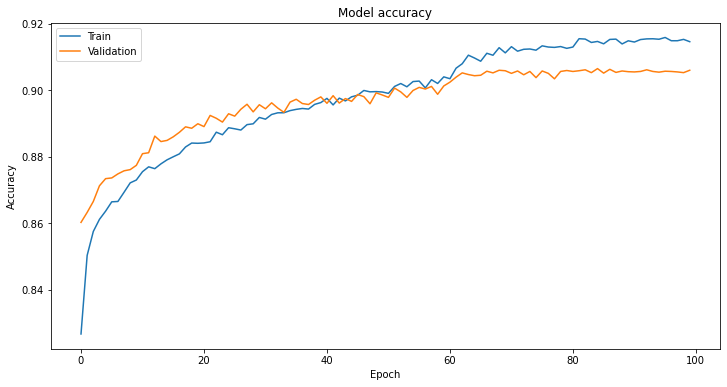

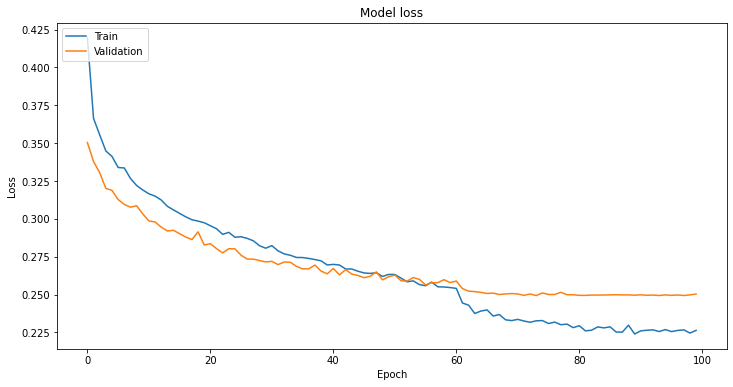

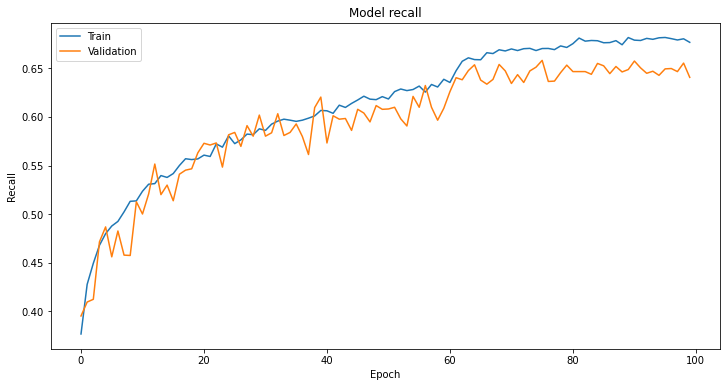

In [64]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation recall values
plt.figure(figsize=(12, 6))
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [65]:
def fgsm_attack(input_data, epsilon, model, true_labels, min_val, max_val):
    input_data = tf.convert_to_tensor(input_data, dtype=tf.float32)
    true_labels = tf.convert_to_tensor(true_labels, dtype=tf.float32)
    
    # Reshape the true_labels tensor to match the predictions shape
    true_labels = tf.reshape(true_labels, (-1, 1))
    
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        predictions = model(input_data)
        loss = tf.keras.losses.binary_crossentropy(true_labels, predictions)
    
    gradients = tape.gradient(loss, input_data)
    signed_grad = tf.sign(gradients)
    adversarial_examples = input_data + epsilon * signed_grad
    adversarial_examples = tf.clip_by_value(adversarial_examples, min_val, max_val)  # Clip values to the valid range
    
    return adversarial_examples.numpy()

# Define a helper function to reverse the scaling
def inverse_scale(X_scaled, numerical_transformer, num_cols):
    X_num = X_scaled[:, :num_cols]
    X_num_inverse = numerical_transformer.inverse_transform(X_num)
    return X_num_inverse

# Get the numerical_transformer from the pipeline
numerical_transformer = pipeline.named_steps['preprocessor'].named_transformers_['num']

# Calculate the number of numerical columns in the transformed dataset
num_numerical_cols = len(numerical_cols)

# Calculate the minimum and maximum values of the unscaled data
min_val = np.min(inverse_scale(X_train, numerical_transformer, num_numerical_cols))
max_val = np.max(inverse_scale(X_train, numerical_transformer, num_numerical_cols))

epsilon = 0.01  # Choose a small value for epsilon (e.g., 0.01)
adversarial_examples = fgsm_attack(X_train, epsilon, improved_model, y_train, min_val, max_val)


In [66]:
from sklearn.metrics import recall_score

# Make predictions on the adversarial examples
adversarial_predictions = (baseline_model.predict(adversarial_examples) > 0.5).astype("int32")

# Calculate the recall score for the minority class on adversarial examples
adversarial_recall = recall_score(y_train, adversarial_predictions)

print(f'Original test recall (minority class): {test_recall}')
print(f'Adversarial recall (minority class): {adversarial_recall}')


2188/2188 [==============================] - 4s 2ms/step
Original test recall (minority class): 0.5644458783674786
Adversarial recall (minority class): 0.4000967920353982


In [67]:
from sklearn.metrics import f1_score

# Make predictions using the improved model
y_pred_proba = improved_model.predict(X_test)

# Initialize the best F1 score and the best threshold
best_f1 = 0
best_threshold = 0

# Iterate through a range of threshold values
for threshold in np.arange(0, 1, 0.01):
    y_pred = (y_pred_proba > threshold).astype(int)
    f1 = f1_score(y_test, y_pred)

    # Update the best F1 score and the best threshold
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Optimal threshold: {best_threshold}")
print(f"Best F1 score: {best_f1}")


938/938 [==============================] - 3s 3ms/step
Optimal threshold: 0.33
Best F1 score: 0.7503549653386787


In [68]:
from sklearn.metrics import recall_score

# Make predictions on the adversarial examples
adversarial_predictions = (baseline_model.predict(adversarial_examples) > 0.33).astype("int32")

# Calculate the recall score for the minority class on adversarial examples
adversarial_recall = recall_score(y_train, adversarial_predictions)

print(f'Original test recall (minority class): {test_recall}')
print(f'Adversarial recall (minority class): {adversarial_recall}')


2188/2188 [==============================] - 5s 2ms/step
Original test recall (minority class): 0.5644458783674786
Adversarial recall (minority class): 0.47310564159292035


938/938 [==============================] - 4s 4ms/step


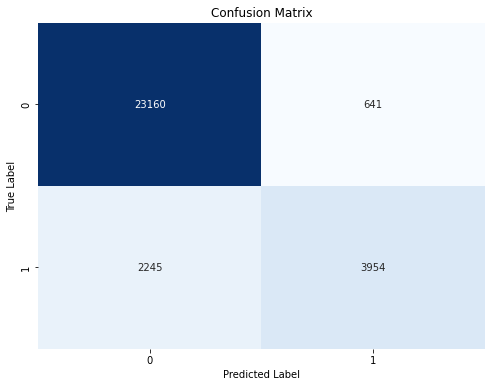

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94     23801
         1.0       0.86      0.64      0.73      6199

    accuracy                           0.90     30000
   macro avg       0.89      0.81      0.84     30000
weighted avg       0.90      0.90      0.90     30000

Cohen's Kappa: 0.6755
Matthews Correlation Coefficient: 0.6868
Average Precision: 0.8338


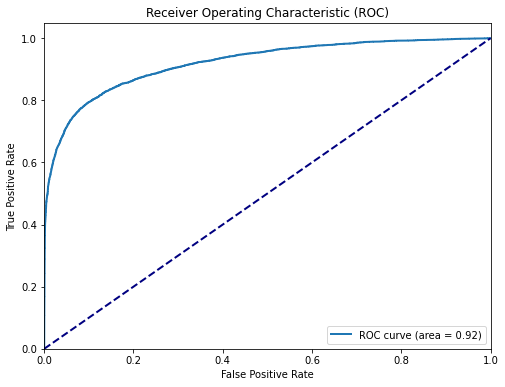

In [74]:
# Make predictions using the improved model
y_pred_proba = improved_model.predict(X_test)

# Convert probabilities to binary class labels
threshold = 0.5
y_pred = (y_pred_proba > threshold).astype(int)



evaluate_classification(y_test, y_pred, y_pred_proba)